In [1]:
%load_ext autoreload
%autoreload 2
import sys
repo_dir = '/home/labs/amit/noamsh/repos/MM_2023'
sys.path.append(repo_dir)

In [5]:
from pathlib import Path
from omegaconf import OmegaConf

import pandas as pd
import numpy as np

import anndata as ad


from io_utils import generate_path_in_output_dir
from data_loading.utils import load_dataframe_from_file

In [3]:
config_path = Path(repo_dir, 'config.yaml')
conf = OmegaConf.load(config_path)

In [6]:
new_hospital_path = Path('/home/labs/amit/noamsh/data/mm_2023/clinical_prediction/Annonymized_CRF_BP_07072024.xlsx')
new_hospital_dataset = load_dataframe_from_file(new_hospital_path)
new_hospital_dataset['Code'] = new_hospital_dataset['Code'].str.lower() # new
print(new_hospital_dataset.shape)
new_hospital_dataset.columns

(262, 127)


Index(['source_project', 'Original Code', 'Code', 'Transcriptome',
       'Patient Code', 'Biopsy sequence No.',
       'Plasma cell dyscrasia at Bx time(0=NDMM, 1=RRMM, 2=SMM 3=MGUS,4=NDAL, 5=RRAL, 6=NDSPC, 7=MGRS, 8=None)',
       'Disease Stage (MGUS=0, SMM=1, NDMM=2, RRMM=3, None=4)', 'Biopsy date',
       'Time from Diagnosis [Years]',
       ...
       'Thalidomide ref.', 'Pomalidomide ref.', 'Cyclophosphamide ref.',
       'Daratumumab ref.', 'Belantamab ref.', 'Talquetamab ref.',
       'Cevostamab ref.', 'Selinexor ref.', 'Auto-SCT ref.', 'CART ref.'],
      dtype='object', length=127)

In [7]:
new_hospital_dataset['Post-Biopsy TL'].value_counts()

Post-Biopsy TL
DKRd            47
CART            46
VCd             11
Seld            11
SelVd           10
DVRd             6
IPd              4
Tal              4
KCd              4
KPd              4
TalTec           4
DVd              3
 ASCT            3
VRd              2
Dd               2
Bela  Chemo      2
VTd              1
VCd ASCT         1
DVRTCd Chemo     1
SelKd            1
VRdCART          1
V                1
DIRd             1
Kd               1
DKd              1
DCd              1
DRd              1
Pd               1
DSel             1
R                1
TCd              1
VenKd            1
DVCd             1
 Chemo           1
DPd              1
Name: count, dtype: int64

### aggregate sample data

In [41]:
date_ts = "2024-06-20"
path = generate_path_in_output_dir(conf, conf.outputs.inferred_missing_annotation_file_name, add_version=True, with_date_timestamp=date_ts)
path

PosixPath('/home/labs/amit/noamsh/repos/MM_2023/outputs/adata_with_scvi_annot_pred_data_v_20240619_ts_2024-06-20.h5ad')

In [5]:
adata = ad.read_h5ad(path)
adata

AnnData object with n_obs × n_vars = 480899 × 3862
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Biopsy.Sequence', 'Previous.Hospital.Code', 'Method', 'cID', 'super_Population', 'Populations', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'Predicted', 'count_of_PC_in_neighborhood', 'count_of_CD45_in_neighborhood', 'pc_with_tme_environment'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Populations_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'log1p', 'neighbors', 'pc', 'super_Population_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', 'pc_X_scVI'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'pc_connectivities', 'pc_distances'

In [6]:
samples_plates_data = adata.obs.groupby(['Hospital.Code', 'Biopsy.Sequence'])[['Disease', 'Project', 'Cohort', "Method"]].agg(pd.Series.mode).dropna()
samples_plates_data.columns.name = None
# samples_plates_data

sample_cells_count = adata.obs.groupby(['Hospital.Code', 'Biopsy.Sequence'])['super_Population'].value_counts().unstack()
sample_cells_count = sample_cells_count.replace(0, np.nan).dropna(how='all').fillna(0)
sample_cells_count.columns.name = None

/tmp/ipykernel_3904043/3636069514.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  samples_plates_data = adata.obs.groupby(['Hospital.Code', 'Biopsy.Sequence'])[['Disease', 'Project', 'Cohort', "Method"]].agg(pd.Series.mode).dropna()
/tmp/ipykernel_3904043/3636069514.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_cells_count = adata.obs.groupby(['Hospital.Code', 'Biopsy.Sequence'])['super_Population'].value_counts().unstack()


In [7]:
samples_data = sample_cells_count.merge(samples_plates_data, how="inner", left_index=True, right_index=True)
samples_data = samples_data.reset_index()
samples_data['Biopsy.Sequence'] = samples_data['Biopsy.Sequence'].astype(int)
samples_data['Hospital.Code'] =  samples_data['Hospital.Code'].str.lower()
samples_data

,Hospital.Code,Biopsy.Sequence,CD45,PC,Disease,Project,Cohort,Method
0,01-001,1,4.0,613.0,RRMM,Kydar,RRMM,MARS
1,01-001,2,148.0,98.0,RRMM,Kydar,RRMM,MARS
2,01-001,3,374.0,97.0,RRMM,Kydar,RRMM,MARS
3,01-002,1,32.0,612.0,RRMM,Kydar,RRMM,MARS
4,01-002,2,49.0,171.0,RRMM,Kydar,RRMM,MARS
...,...,...,...,...,...,...,...,...
424,hipb13,1,495.0,9.0,Healthy,Healthy,Healthy,MARS
425,hipb14,1,1715.0,73.0,Healthy,Healthy,Healthy,MARS
426,hipb15,1,613.0,13.0,Healthy,Healthy,Healthy,MARS
427,hipb17,1,222.0,0.0,Healthy,Healthy,Healthy,MARS


In [42]:
# import plotly.express as px
# # samples_data.plot.scatter(x="CD45", y="PC")
# fig = px.scatter(samples_data, x="CD45", y="PC", color="Method", symbol="Biopsy.Sequence", hover_data=['Hospital.Code', "Project"])
# fig.show()

In [10]:
merged_sample_data = samples_data.merge(new_hospital_dataset, how='left', left_on=['Hospital.Code', 'Biopsy.Sequence'], right_on=['Code', 'Biopsy sequence No.'], validate='m:1')

### Disease stage label annotation

In [11]:
hospital_stage = 'Plasma cell dyscrasia at Bx time(0=NDMM, 1=RRMM, 2=SMM 3=MGUS,4=NDAL, 5=RRAL, 6=NDSPC, 7=MGRS, 8=None)'
hospital_stage_map = {0: 'NDMM', 1: "RRMM", 2: "SMM", 3: "MGUS", 4: "AL", 5:"AL", 6:"MGUS", 7:"MGUS", 8:None}
merged_sample_data['Disease Stage Hospital'] = merged_sample_data[hospital_stage].map(hospital_stage_map)
# merged_sample_data['Disease_with_update']


In [26]:
## pateints level
patient_lvl_disease_count = pd.concat([merged_sample_data.drop_duplicates("Hospital.Code")["Disease"].value_counts().rename("all patients"),
          merged_sample_data.drop_duplicates("Hospital.Code")['Disease Stage Hospital'].value_counts().rename("with clinical data")]
          , axis=1)
patient_lvl_disease_count= pd.concat([patient_lvl_disease_count, pd.DataFrame(patient_lvl_disease_count.sum().rename("sum")).T], axis=0)
patient_lvl_disease_count

,all patients,with clinical data
RRMM,234.0,146.0
Healthy,54.0,NaN
NDMM,24.0,49.0
MGUS,12.0,14.0
SMM,10.0,12.0
AL,5.0,12.0
MM_Unknown,4.0,NaN
EMD,1.0,NaN
sum,344.0,233.0


In [27]:
## sapmle level
hispital_stage_vc = merged_sample_data['Disease Stage Hospital'].value_counts().rename("with clinical data")
sample_lvl_disease_count = pd.concat([merged_sample_data["Disease"].value_counts().rename("all samples"),
                                       hispital_stage_vc], axis=1)
sample_lvl_disease_count= pd.concat([sample_lvl_disease_count, pd.DataFrame(sample_lvl_disease_count.sum().rename("sum")).T], axis=0)
sample_lvl_disease_count

,all samples,with clinical data
RRMM,318.0,160.0
Healthy,54.0,NaN
NDMM,24.0,49.0
MGUS,12.0,14.0
SMM,10.0,12.0
AL,5.0,12.0
MM_Unknown,5.0,NaN
EMD,1.0,NaN
sum,429.0,247.0


In [28]:
for stage in ["MGUS", "SMM", "NDMM", "RRMM"]:
    print(stage)
    our_mask = merged_sample_data["Disease"] == stage
    hospital_mask = merged_sample_data['Disease Stage Hospital'] == stage
    print(merged_sample_data[(our_mask & (~ hospital_mask)) | ((~our_mask) & hospital_mask)][['Hospital.Code', 'Method', 'Disease', 'Disease Stage Hospital']].dropna())

MGUS
    Hospital.Code Method Disease Disease Stage Hospital
224         hmc09   MARS    NDMM                   MGUS
321         tlv19   MARS     SMM                   MGUS
326         tlv25   MARS    NDMM                   MGUS
376         tlv95   SPID    RRMM                   MGUS
SMM
    Hospital.Code Method Disease Disease Stage Hospital
321         tlv19   MARS     SMM                   MGUS
329         tlv29   MARS    NDMM                    SMM
351         tlv64   SPID    RRMM                    SMM
352         tlv65   SPID    RRMM                    SMM
370         tlv86   SPID    NDMM                    SMM
NDMM
    Hospital.Code Method Disease Disease Stage Hospital
120      cart_p08   SPID    RRMM                   NDMM
224         hmc09   MARS    NDMM                   MGUS
231         hmc17   MARS      AL                   NDMM
326         tlv25   MARS    NDMM                   MGUS
329         tlv29   MARS    NDMM                    SMM
338         tlv47   MARS    RRMM  

In [29]:
merged_sample_data["Disease"].update(merged_sample_data['Disease Stage Hospital'].dropna())

/tmp/ipykernel_3904043/2284508612.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [33]:

updated_patient_lvl_disease_count=pd.concat([merged_sample_data.drop_duplicates("Hospital.Code")["Disease"].value_counts().rename("all patients"),
          merged_sample_data.drop_duplicates("Hospital.Code")['Disease Stage Hospital'].value_counts().rename("with clinical data")]
          , axis=1)
updated_patient_lvl_disease_count = pd.concat([updated_patient_lvl_disease_count,
                                               pd.DataFrame(updated_patient_lvl_disease_count.sum().rename("sum")).T], axis=0)
updated_patient_lvl_disease_count

,all patients,with clinical data
RRMM,188.0,146.0
NDMM,57.0,49.0
Healthy,54.0,NaN
MGUS,16.0,14.0
SMM,13.0,12.0
AL,12.0,12.0
MM_Unknown,4.0,NaN
EMD,0.0,NaN
sum,344.0,233.0


In [34]:
## sapmle level
updated_sample_lvl_disease_count = pd.concat([merged_sample_data["Disease"].value_counts().rename("all samples"), hispital_stage_vc], axis=1)
updated_sample_lvl_disease_count = pd.concat([updated_sample_lvl_disease_count,
                                               pd.DataFrame(updated_sample_lvl_disease_count.sum().rename("sum")).T], axis=0)
updated_sample_lvl_disease_count

,all samples,with clinical data
RRMM,272.0,160.0
NDMM,57.0,49.0
Healthy,54.0,NaN
MGUS,16.0,14.0
SMM,13.0,12.0
AL,12.0,12.0
MM_Unknown,5.0,NaN
EMD,0.0,NaN
sum,429.0,247.0


### explore response

In [35]:
from clinical_predictions.clinical_data_loading import add_response_columns_to_drug_combination, add_response_columns_to_specific_treatment

In [36]:
# merged_sample_data[(~merged_sample_data[merged_sample_data.columns[merged_sample_data.columns.str.contains("\.2")]].isna()).sum(axis=1) ==1]

In [37]:
# Bortezomib	Ixazomib	Carfilzomib	Lenalidomide	Thalidomide	Pomalidomide	Cyclophosphamide	Chemotherapy	Venetoclax	Dexamethasone	Prednisone	Daratumumab	Elotuzumab	Belantamab	Talquetamab	Teclistamab	Cevostamab	Selinexor	Auto-SCT	CART	BiTE-BCMA
# all treatments = ["CART", "Lenalidomide", "Daratumumab", "Bortezomib", "Ixazomib", "Carfilzomib", "Thalidomide", "Pomalidomide", "Cyclophosphamide", "Chemotherapy", "Venetoclax", "Dexamethasone", "Prednisone", "Elotuzumab", "Belantamab", "Talquetamab", "Teclistamab", "Cevostamab", "Selinexor", "Auto-SCT"]
treatments = ["CART", "Lenalidomide", "Daratumumab", "Bortezomib", "Carfilzomib", "Pomalidomide", "Cyclophosphamide", "Dexamethasone", "Selinexor", "Chemotherapy"]
R_NR_policys = ['post-treatment', 'full'] #
values = []
index_tuples = []
for treatment in treatments:
    for R_NR_policy in R_NR_policys:
        if R_NR_policy == 'post-treatment':
            response_policy = 'post_sensitive'
            no_response_policy = 'post_refractory'
        elif R_NR_policy == 'full':
            response_policy = 'NDMM_SMM|post_sensitive'
            no_response_policy = 'pre_refractory|post_refractory'
        else:
            raise ValueError

        df_with_response = add_response_columns_to_specific_treatment(merged_sample_data, treatment,
                                                                      response_policy=response_policy,
                                                                      no_response_policy=no_response_policy,
                                                                      raise_errors=False)
        # df_with_response[f"{treatment}_response"].value_counts()
        values.append(dict(df_with_response[f"{treatment}_response"].value_counts()))
        index_tuples.append((treatment, R_NR_policy))

/home/labs/amit/noamsh/repos/MM_2023/clinical_predictions/clinical_data_loading.py:164: UserWarning:

some patients follow both response and no response policies for treatment: CART
will consider them as non responders

    Hospital.Code  Biopsy.Sequence   CD45    PC Disease Project Cohort Method  \
120      cart_p08                1  390.0  14.0    NDMM    CART   CART   SPID   

     CART  CART.2 CART_response  \
120   1.0     2.0            NR   

     Plasma cell dyscrasia at Bx time(0=NDMM, 1=RRMM, 2=SMM 3=MGUS,4=NDAL, 5=RRAL, 6=NDSPC, 7=MGRS, 8=None)  
120                                                0.0                                                        

/home/labs/amit/noamsh/repos/MM_2023/clinical_predictions/clinical_data_loading.py:164: UserWarning:

some patients follow both response and no response policies for treatment: Lenalidomide
will consider them as non responders

    Hospital.Code  Biopsy.Sequence    CD45      PC Disease Project Cohort  \
120      cart_p08  

In [38]:
index = pd.MultiIndex.from_tuples(index_tuples, names=["Treatment", "patients policy"])
df = pd.DataFrame(values, index=index)
df["sum"]= df.sum(axis=1)
df["R prop"]= df['R'] / df['sum']

df.T.round(2)
# pandas. values, index_tuples

Treatment                 CART          Lenalidomide            Daratumumab  \
patients policy post-treatment   full post-treatment    full post-treatment   
R                         45.0  114.0            NaN   66.00            NaN   
NR                        11.0   12.0            8.0  115.00           10.0   
sum                       56.0  126.0            8.0  181.00           10.0   
R prop                     0.8    0.9            NaN    0.36            NaN   

Treatment                   Bortezomib            Carfilzomib          \
patients policy    full post-treatment    full post-treatment    full   
R                 66.00            NaN   65.00            NaN   70.00   
NR               117.00            7.0  117.00            8.0   64.00   
sum              183.00            7.0  182.00            8.0  134.00   
R prop             0.36            NaN    0.36            NaN    0.52   

Treatment         Pomalidomide         Cyclophosphamide          \
patients policy post-treatment    full   post-treatment    full   
R                          NaN   70.00              NaN   69.00   
NR                         3.0   74.00              3.0   33.00   
sum                        3.0  144.00              3.0  102.00   
R prop                     NaN    0.49              NaN    0.68   

Treatment        Dexamethasone              Selinexor          Chemotherapy  \
patients policy post-treatment    full post-treatment   full post-treatment   
R                          NaN   66.00            NaN  70.00            NaN   
NR                        22.0   85.00            8.0  11.00            1.0   
sum                       22.0  151.00            8.0  81.00            1.0   
R prop                     NaN    0.44            NaN   0.86            NaN   

Treatment               
patients policy   full  
R                70.00  
NR                3.00  
sum              73.00  
R prop            0.96

In [39]:
combinations = ['Penta', 'Triple']
R_NR_policys = ['post-treatment', 'full'] #
values = []
index_tuples = []
for comb in combinations:
    for R_NR_policy in R_NR_policys:
        if R_NR_policy == 'post-treatment':
            response_policy = 'exposed_non_refractory'
            no_response_policy = 'refractory'
        elif R_NR_policy == 'full':
            response_policy = 'NDMM_SMM|exposed_non_refractory'
            no_response_policy = 'refractory'
        else:
            raise ValueError

        df_with_response = add_response_columns_to_drug_combination(merged_sample_data, comb,
                                                                      response_policy=response_policy,
                                                                      no_response_policy=no_response_policy,
                                                                      raise_errors=False)
        # df_with_response[f"{treatment}_response"].value_counts()
        values.append(dict(df_with_response[f"{comb}_response"].value_counts()))
        index_tuples.append((comb, R_NR_policy))


In [40]:
index = pd.MultiIndex.from_tuples(index_tuples, names=["Treatment", "patients policy"])
df_comb = pd.DataFrame(values, index=index)
df_comb["sum"]= df_comb.sum(axis=1)
df_comb["R prop"]= df_comb['R'] / df_comb['sum']
df_comb.T.round(2)

Treatment                Penta                Triple       
patients policy post-treatment   full post-treatment   full
NR                       23.00   23.0          89.00   89.0
R                        21.00   91.0          43.00   90.0
sum                      44.00  114.0         132.00  179.0
R prop                    0.48    0.8           0.33    0.5

### explore potentials patients duplications, by diffrent ids

In [37]:
new_hospital_dataset[new_hospital_dataset['Code'].duplicated()]

,source_project,Original Code,Code,Transcriptome,Patient Code,Biopsy sequence No.,"Plasma cell dyscrasia at Bx time(0=NDMM, 1=RRMM, 2=SMM 3=MGUS,4=NDAL, 5=RRAL, 6=NDSPC, 7=MGRS, 8=None)","Disease Stage (MGUS=0, SMM=1, NDMM=2, RRMM=3, None=4)",Biopsy date,Time from Diagnosis [Years],...,Thalidomide ref.,Pomalidomide ref.,Cyclophosphamide ref.,Daratumumab ref.,Belantamab ref.,Talquetamab ref.,Cevostamab ref.,Selinexor ref.,Auto-SCT ref.,CART ref.
41,TLV,TLV83,TLV71,False,BP_041,2,1,3,2023-08-30 00:00:00,11.247222,...,1,1,0,1,1,0,0,0,0,0
52,TLV,TLV76,TLV76,NaN,BP_051,2,1,3,2023-01-16 00:00:00,19.041667,...,0,1,1,1,1,1,0,0,0,1
54,TLV,TLV88,TLV77,NaN,BP_052,2,1,3,2023-11-07 00:00:00,1.305556,...,0,1,0,1,0,0,0,0,0,0
59,CSA,CSA-01-03 DN,CSA-01-03,False,BP_057,2,1,3,2021-10-19 00:00:00,8.163889,...,0,1,1,1,1,0,0,1,0,0
62,KYDAR,01-001,01-001,True,BP_060,3,1,3,2019-02-10 00:00:00,2.025000,...,0,1,0,1,0,0,0,0,0,0
65,KYDAR,01-003,01-003,NaN,BP_063,2,1,3,2018-11-22 00:00:00,1.647222,...,0,0,1,0,0,0,0,0,0,0
68,KYDAR,01-005,01-005,True,BP_065,3,1,3,2019-10-31 00:00:00,2.533333,...,0,0,0,1,0,0,0,0,0,0
71,KYDAR,01-007,01-007,True,BP_068,2,1,3,2019-03-25 00:00:00,0.566667,...,1,0,0,0,0,0,0,0,1,0
73,KYDAR,01-008,01-008,True,BP_070,2,1,3,2019-06-03 00:00:00,1.083333,...,0,0,1,0,0,0,0,0,0,0
74,KYDAR,01-008,01-008,True,BP_070,3,1,3,2019-12-01 00:00:00,1.577778,...,0,0,1,0,0,0,0,0,0,0


In [38]:
new_hospital_dataset[new_hospital_dataset['Patient Code'].duplicated()]

,source_project,Original Code,Code,Transcriptome,Patient Code,Biopsy sequence No.,"Plasma cell dyscrasia at Bx time(0=NDMM, 1=RRMM, 2=SMM 3=MGUS,4=NDAL, 5=RRAL, 6=NDSPC, 7=MGRS, 8=None)","Disease Stage (MGUS=0, SMM=1, NDMM=2, RRMM=3, None=4)",Biopsy date,Time from Diagnosis [Years],...,Thalidomide ref.,Pomalidomide ref.,Cyclophosphamide ref.,Daratumumab ref.,Belantamab ref.,Talquetamab ref.,Cevostamab ref.,Selinexor ref.,Auto-SCT ref.,CART ref.
41,TLV,TLV83,TLV71,False,BP_041,2,1,3,2023-08-30 00:00:00,11.247222,...,1,1,0,1,1,0,0,0,0,0
52,TLV,TLV76,TLV76,NaN,BP_051,2,1,3,2023-01-16 00:00:00,19.041667,...,0,1,1,1,1,1,0,0,0,1
54,TLV,TLV88,TLV77,NaN,BP_052,2,1,3,2023-11-07 00:00:00,1.305556,...,0,1,0,1,0,0,0,0,0,0
59,CSA,CSA-01-03 DN,CSA-01-03,False,BP_057,2,1,3,2021-10-19 00:00:00,8.163889,...,0,1,1,1,1,0,0,1,0,0
62,KYDAR,01-001,01-001,True,BP_060,3,1,3,2019-02-10 00:00:00,2.025000,...,0,1,0,1,0,0,0,0,0,0
65,KYDAR,01-003,01-003,NaN,BP_063,2,1,3,2018-11-22 00:00:00,1.647222,...,0,0,1,0,0,0,0,0,0,0
68,KYDAR,01-005,01-005,True,BP_065,3,1,3,2019-10-31 00:00:00,2.533333,...,0,0,0,1,0,0,0,0,0,0
71,KYDAR,01-007,01-007,True,BP_068,2,1,3,2019-03-25 00:00:00,0.566667,...,1,0,0,0,0,0,0,0,1,0
73,KYDAR,01-008,01-008,True,BP_070,2,1,3,2019-06-03 00:00:00,1.083333,...,0,0,1,0,0,0,0,0,0,0
74,KYDAR,01-008,01-008,True,BP_070,3,1,3,2019-12-01 00:00:00,1.577778,...,0,0,1,0,0,0,0,0,0,0


In [39]:
new_hospital_dataset[new_hospital_dataset['Biopsy sequence No.'] != 1]  # should be the same 

,source_project,Original Code,Code,Transcriptome,Patient Code,Biopsy sequence No.,"Plasma cell dyscrasia at Bx time(0=NDMM, 1=RRMM, 2=SMM 3=MGUS,4=NDAL, 5=RRAL, 6=NDSPC, 7=MGRS, 8=None)","Disease Stage (MGUS=0, SMM=1, NDMM=2, RRMM=3, None=4)",Biopsy date,Time from Diagnosis [Years],...,Thalidomide ref.,Pomalidomide ref.,Cyclophosphamide ref.,Daratumumab ref.,Belantamab ref.,Talquetamab ref.,Cevostamab ref.,Selinexor ref.,Auto-SCT ref.,CART ref.
41,TLV,TLV83,TLV71,False,BP_041,2,1,3,2023-08-30 00:00:00,11.247222,...,1,1,0,1,1,0,0,0,0,0
52,TLV,TLV76,TLV76,NaN,BP_051,2,1,3,2023-01-16 00:00:00,19.041667,...,0,1,1,1,1,1,0,0,0,1
54,TLV,TLV88,TLV77,NaN,BP_052,2,1,3,2023-11-07 00:00:00,1.305556,...,0,1,0,1,0,0,0,0,0,0
59,CSA,CSA-01-03 DN,CSA-01-03,False,BP_057,2,1,3,2021-10-19 00:00:00,8.163889,...,0,1,1,1,1,0,0,1,0,0
62,KYDAR,01-001,01-001,True,BP_060,3,1,3,2019-02-10 00:00:00,2.025000,...,0,1,0,1,0,0,0,0,0,0
65,KYDAR,01-003,01-003,NaN,BP_063,2,1,3,2018-11-22 00:00:00,1.647222,...,0,0,1,0,0,0,0,0,0,0
68,KYDAR,01-005,01-005,True,BP_065,3,1,3,2019-10-31 00:00:00,2.533333,...,0,0,0,1,0,0,0,0,0,0
71,KYDAR,01-007,01-007,True,BP_068,2,1,3,2019-03-25 00:00:00,0.566667,...,1,0,0,0,0,0,0,0,1,0
73,KYDAR,01-008,01-008,True,BP_070,2,1,3,2019-06-03 00:00:00,1.083333,...,0,0,1,0,0,0,0,0,0,0
74,KYDAR,01-008,01-008,True,BP_070,3,1,3,2019-12-01 00:00:00,1.577778,...,0,0,1,0,0,0,0,0,0,0


### explore potential patien_id changes

In [10]:
import anndata as ad
import scanpy as sc
import numpy as np

from io_utils import generate_path_in_output_dir

In [44]:
load_ts_iso = "2024-05-19"
data_version = "20240515"

# load_ts_iso = "2024-05-21"
# data_version = "20240519"

In [45]:
## these are the patients that changed mannualy in our data to be 2 samples of one patient

patients_to_plot = [
    'CSA-01-05','TLV50', # same biopsy
    'CSA-01-01', 'TLV76', # one mars one SPID
    'TLV77', 'TLV88', # both SPID + 77 is pre 88 is post
    'CSA-01-03', 'CSA-01-03 DN', # CSA-01-03 DN is post, only CD45 plates from CSA-01-03 DN
    '028-0603-002','CART_P10', # one mars one SPID
    'TLV71', 'TLV83',
]

In [34]:
adata_for_clustering = ad.read_h5ad(generate_path_in_output_dir(conf, conf.outputs.inferred_missing_annotation_file_name,
                                                 with_version=data_version, with_date_timestamp=load_ts_iso))
drop_diseases = ('In_vitro', 'Ex_vivo')
adata_for_clustering = adata_for_clustering[adata_for_clustering.obs[conf.annotation.Disease].apply(lambda x: x not in drop_diseases)].copy()
adata_for_clustering.obs["Populations"][adata_for_clustering.obs["super_Population"] == "PC"] = "PC"
# adata_for_clustering.obs["Populations"][adata_for_clustering.obs["Populations"].apply(lambda x: x in ('UN', 'Malignant'))] = ""
adata_for_clustering = adata_for_clustering[adata_for_clustering.obs["Populations"].apply(lambda x: x not in ("Erythrocytes", 'UN', 'Malignant'))]
adata_for_clustering

/tmp/ipykernel_38921/3309661671.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata_for_clustering.obs["Populations"][adata_for_clustering.obs["super_Population"] == "PC"] = "PC"


View of AnnData object with n_obs × n_vars = 480899 × 3862
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Method', 'cID', 'super_Population', 'Populations', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'Predicted', 'count_of_PC_in_neighborhood', 'count_of_CD45_in_neighborhood', 'pc_with_tme_environment'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'log1p', 'neighbors', 'pc', 'umap'
    obsm: 'X_scVI', 'X_umap', 'pc_X_scVI'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'pc_connectivities', 'pc_distances'

In [27]:
for p in patients_to_plot:
    p_mask = adata_for_clustering.obs['Hospital.Code'] == p
    adata_for_clustering.obs[p] = np.nan
    adata_for_clustering.obs[p][p_mask] = p

/tmp/ipykernel_38921/1127741249.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata_for_clustering.obs[p][p_mask] = p
/tmp/ipykernel_38921/1127741249.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

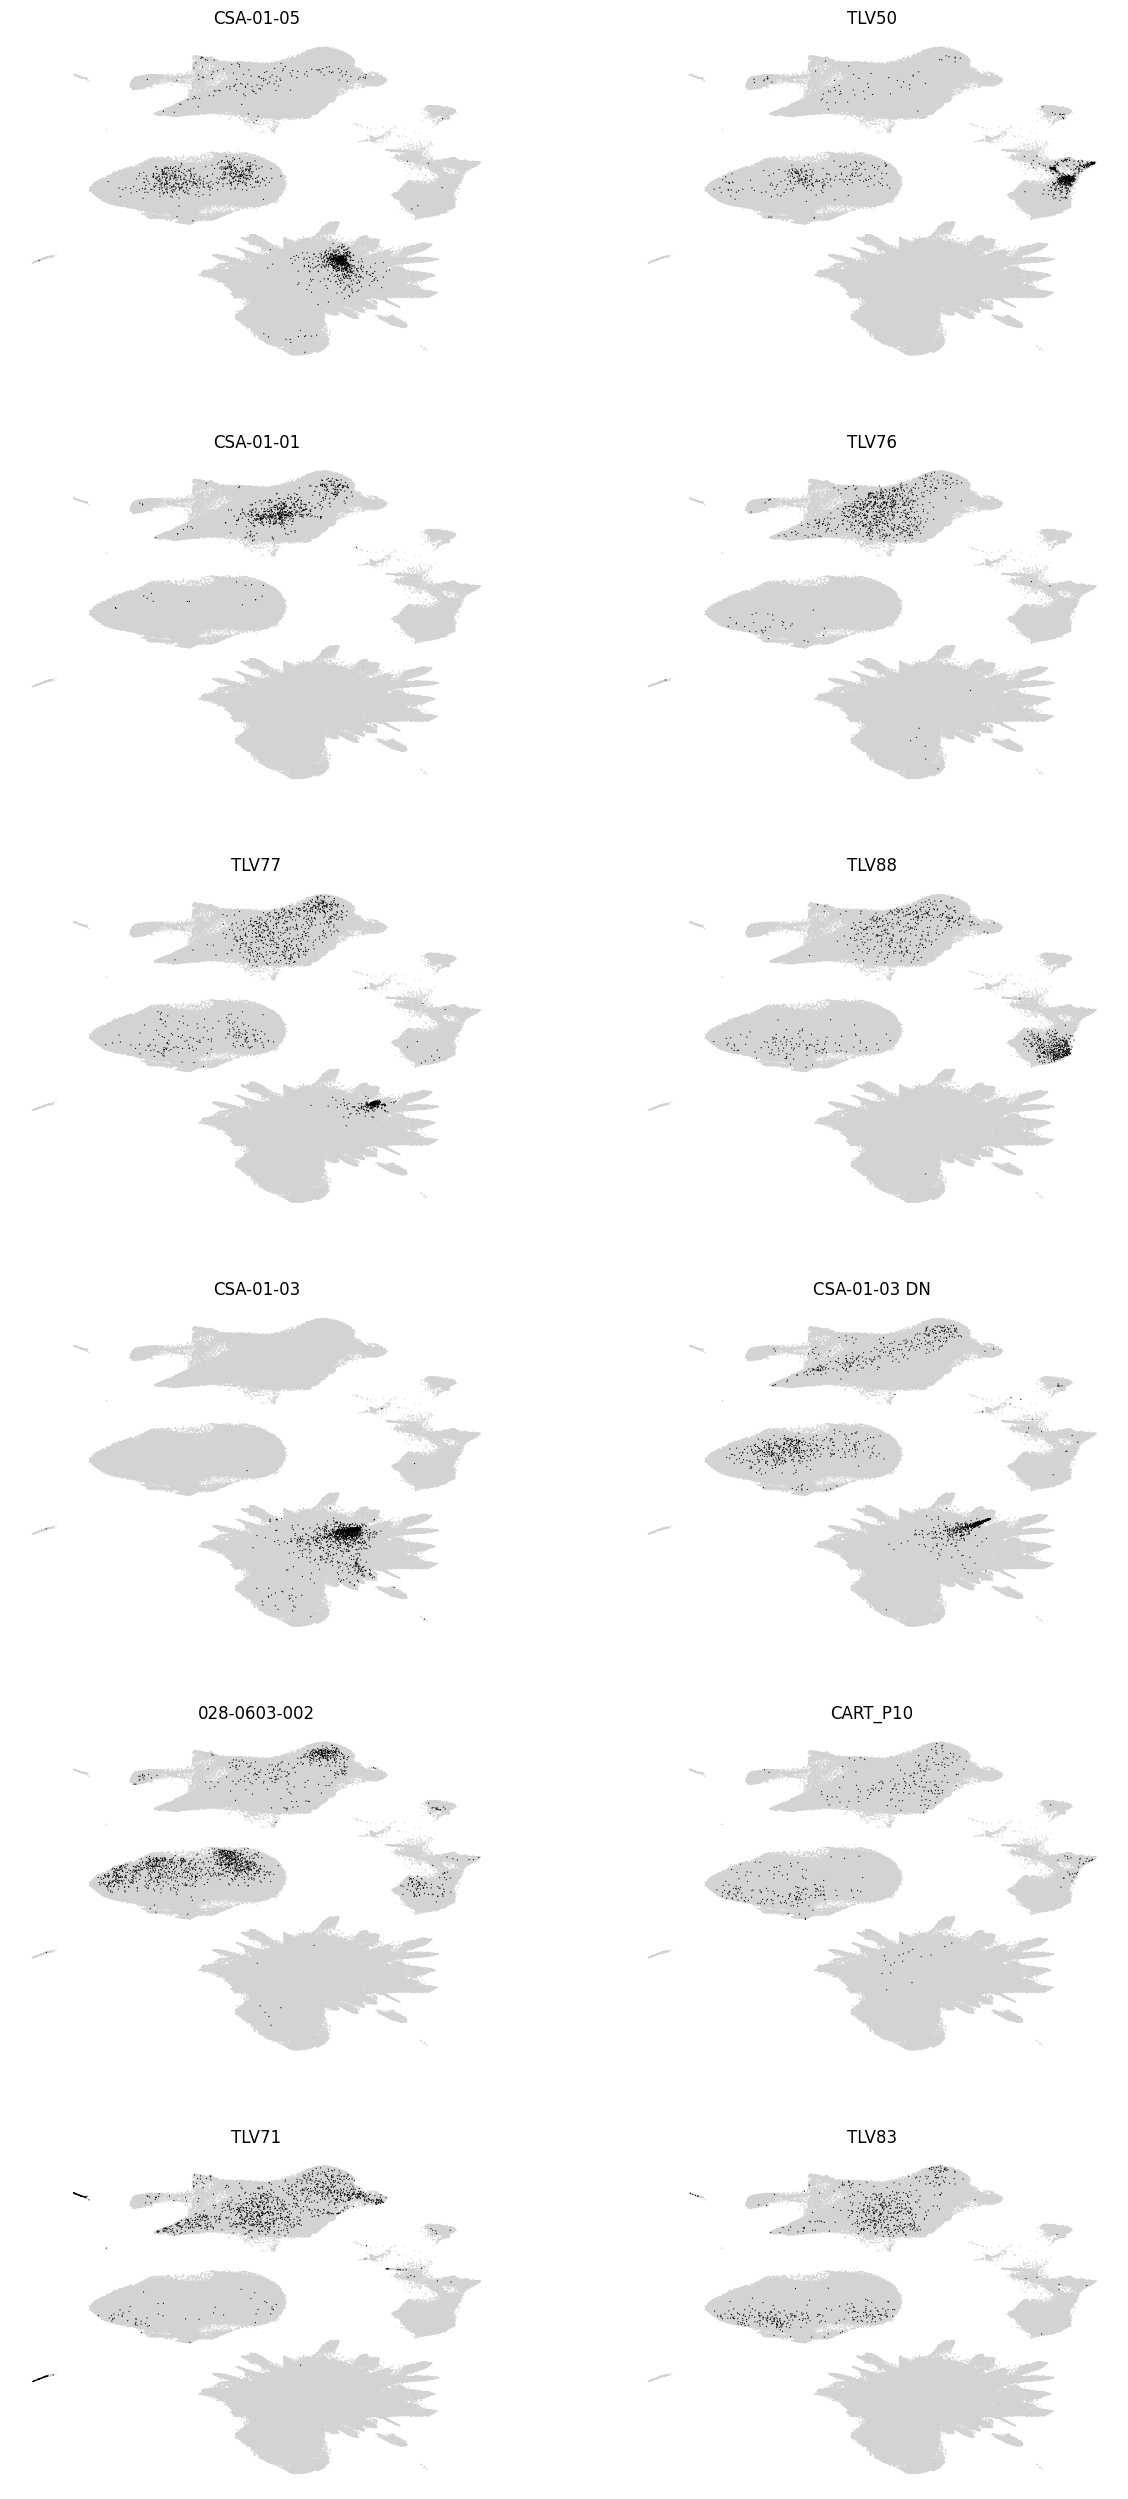

In [28]:
sc.pl.umap(adata_for_clustering, color=patients_to_plot, ncols=2, frameon=False, legend_loc=None, palette="gist_gray", size=3)

In [29]:
######

In [30]:
annotated_filtered_only_pc_path = Path(conf.outputs.output_dir, f"adata_with_scvi_annot_pred_data_v_{data_version}_ts_{load_ts_iso}_only_pc_annotated_filtered.h5ad")
non_noisy_malignant = ad.read_h5ad(annotated_filtered_only_pc_path)

In [31]:
for p in patients_to_plot:
    p_mask = non_noisy_malignant.obs['Hospital.Code'] == p
    non_noisy_malignant.obs[p] = np.nan
    non_noisy_malignant.obs[p][p_mask] = p

/tmp/ipykernel_38921/192663909.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  non_noisy_malignant.obs[p][p_mask] = p
/tmp/ipykernel_38921/192663909.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

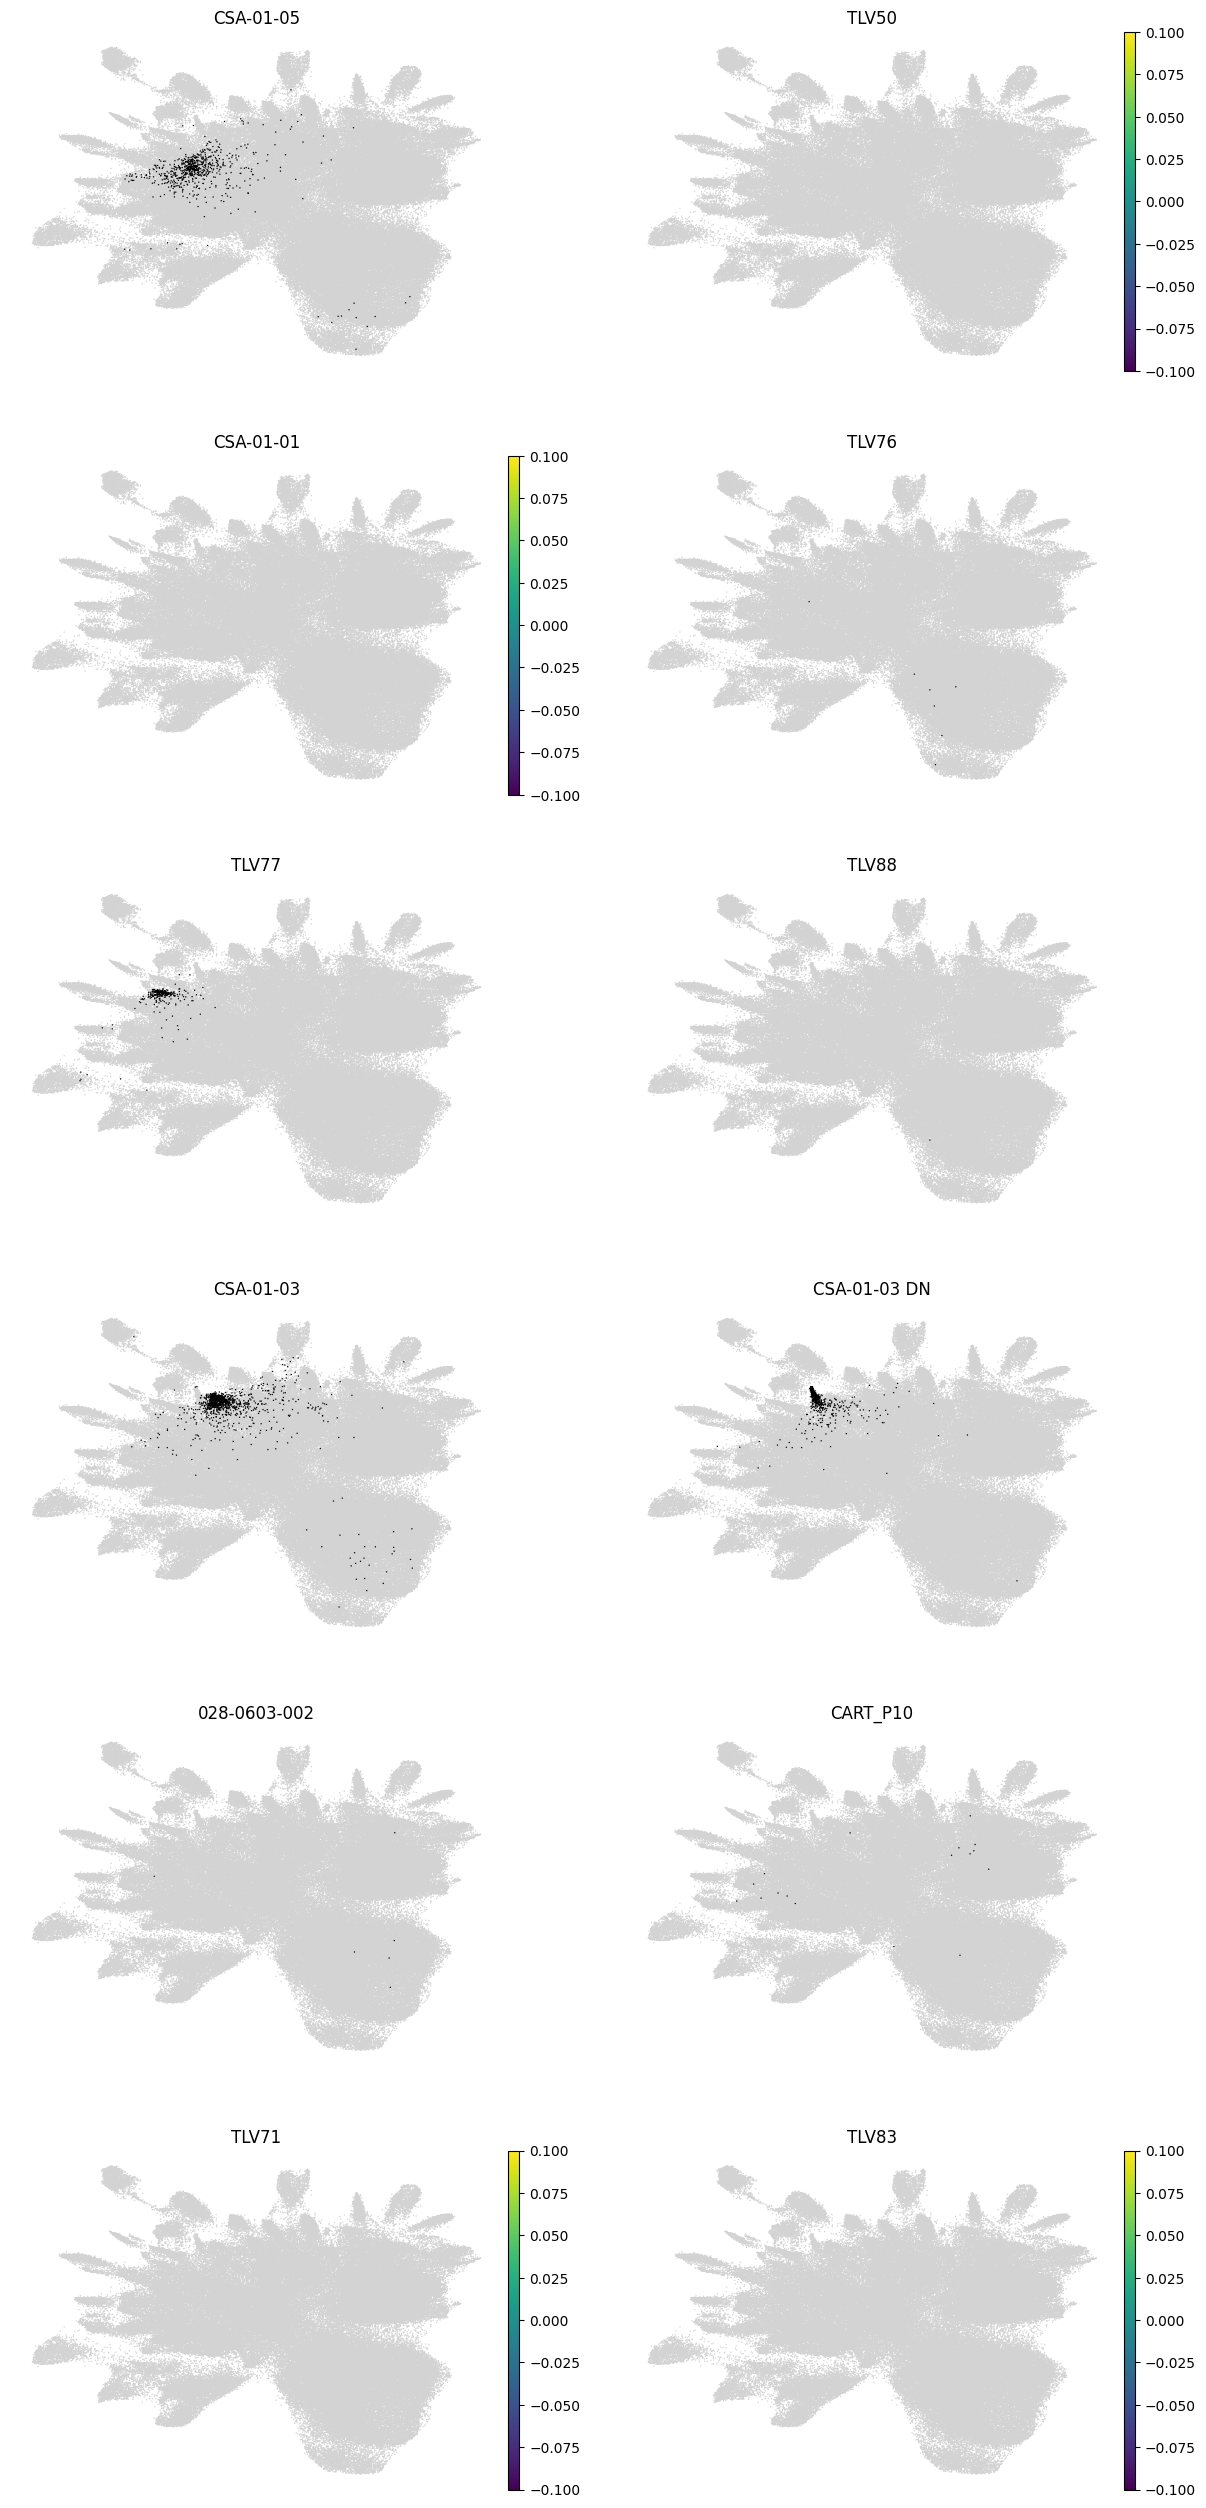

In [32]:
sc.pl.umap(non_noisy_malignant, color=patients_to_plot, ncols=2, frameon=False, legend_loc=None, palette="gist_gray", size=4)

### merge patient features on clinical data

In [ ]:
plates_paths = conf.data_loading.plates.plates_data_path
plates_df = pd.concat([load_dataframe_from_file(Path(path)) for path in plates_paths])
plates_df

In [10]:
new_hospital_dataset.shape, plates_df.shape

((223, 127), (2536, 22))

In [61]:
plates_df['Biopsy.Sequence'] = plates_df['Biopsy.Sequence'].fillna(1).astype(int)

In [63]:
plates_df.groupby(by=['Hospital.Code', 'Biopsy.Sequence'])['Amp.Batch.ID'].count().reset_index()['Biopsy.Sequence'].value_counts()

Biopsy.Sequence
1    332
2     65
3     32
4      2
Name: count, dtype: int64

In [65]:
merged = plates_df.merge(new_hospital_dataset, how='left', left_on=['Hospital.Code', 'Biopsy.Sequence'], right_on=['Code', 'Biopsy sequence No.'], validate='m:1')
(merged.groupby(by=['Hospital.Code', 'Biopsy.Sequence'])['Patient Code'].nunique()).value_counts()
# see that after join on "Code" in hospital data no duplication in 'Patient Code'

Patient Code
0    234
1    197
Name: count, dtype: int64

In [70]:
merged[~merged["Patient Code"].isna()]

,Amp.Batch.ID,Seq.Batch.ID,Batch.Set.ID,Member,Description,Included,Tissue,Gating,Total.PC,Total.NonPC,...,Thalidomide ref.,Pomalidomide ref.,Cyclophosphamide ref.,Daratumumab ref.,Belantamab ref.,Talquetamab ref.,Cevostamab ref.,Selinexor ref.,Auto-SCT ref.,CART ref.
27,AB2554,SB132,human_BM,Guy,TLV07_PC_1,No,BM,PC,360.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,AB2555,SB132,human_BM,Guy,TLV07_PC_2,No,BM,PC,352.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,AB2556,SB132,human_BM,Guy,TLV07_CD45_1,No,BM,CD45,2.0,213.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,AB2557,SB132,human_BM,Guy,TLV07_CD45_2,No,BM,CD45,1.0,243.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,AB2558,SB132,human_BM,Guy,TLV07_CD45_3,No,BM,CD45,3.0,227.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2336,AB13716,SB224,SPID_V18,NaN,NaN,-,BM,PC,233.0,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2339,AB13758,SB225,SPID_V18,NaN,NaN,-,BM,CD45,2.0,268.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2346,AB13765,SB225,SPID_V18,NaN,NaN,-,BM,PC,302.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2347,AB13766,SB225,SPID_V18,NaN,NaN,-,BM,PC,313.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
raw_hospital_dataset.rename({'Plasma cell dyscrasia at Bx time(0=NDMM, 1=RRMM, 2=SMM 3=MGUS,4=NDAL, 5=RRAL, 6=NDSPC, 7=MGRS, 8=None)': "Time"})

Index(['source_project', 'Code', 'Transcriptome', 'Patient Code',
       'Plasma cell dyscrasia at Bx time(0=NDMM, 1=RRMM, 2=SMM 3=MGUS,4=NDAL, 5=RRAL, 6=NDSPC, 7=MGRS, 8=None)',
       'Disease Stage (MGUS=0, SMM=1, NDMM=2, RRMM=3, None=4)', 'Biopsy date',
       'Time from Diagnosis [Years]', 'DOB', 'age at Bx',
       ...
       'Thalidomide.3', 'Pomalidomide.3', 'Cyclophosphamide.3',
       'Daratumumab.3', 'Belantamab.4', 'Talquetamab.3', 'Cevostamab.3',
       'Selinexor.3', 'Auto-SCT.3', 'CART.3'],
      dtype='object', length=125)

In [12]:
from clinical_predictions.clinical_data_loading import merge_transcriptom_data_to_raw_hospital

# remove no-transcriptom patients
# add post treatment columns from hospital
# add data to TAL_3 patients

dataset = merge_transcriptom_data_to_raw_hospital(raw_dataset, raw_hospital_dataset, filter_transcriptome_dataset_by_col=None, transcriptome_dataset_patient_id_col_name=None)
dataset

KeyError: 'Time'